# Classification Modelling

In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from tqdm.notebook import tqdm_notebook

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from collections import Counter
from imblearn.over_sampling import SMOTENC

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

## Load Dataset

In [2]:
# Please change the below path to where your data is stored
DATA_PATH = "/mnt/e/Projects/classification/customer_churn/data/Bank Customer Churn Prediction.csv"

In [3]:
df = pd.read_csv(DATA_PATH)
df.shape

(10000, 12)

In [4]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
df["churn"].value_counts(normalize=True)

churn
0    0.7963
1    0.2037
Name: proportion, dtype: float64

Class imbalance seen. The minority class (churned customers) constitute only about 20% of the data. To get a benchmark score, first let's build models without handling class imbalance. Later, we'll use SMOTE to increase minority data samples and see how performance improves.

## Data preparation

In [6]:
TEST_SIZE = 0.2
RANDOM_SEED = 10
K_FOLDS = 5
SCORING = "recall"

We want to look at models with high recall as it would mean that we have low false negatives. False negatives in our case would mean that we have classified customers as someone who doesn't churn, while in fact, they actually do. This is also known as Type - 2 error.

We'd be willing to tolerate the mistake of classifying customers as someone who will churn (when they actually don't). But, it is costly to make the mistake of classifying customers as someone who won't churn, but they end up churning (or leaving the bank).

Thus, we optimize for recall.

In [9]:
Y = df["churn"]
X = df.drop(columns=["customer_id", "churn"])

In [10]:
categorical_variables = ["country", "gender"]
scaling_variables = ["credit_score", "age", "tenure", "balance", "products_number", "estimated_salary"]

### Encoding categorical features

In [11]:
ohe = OneHotEncoder(drop="first")

In [12]:
ohe.fit(X[categorical_variables])

OneHotEncoder(drop='first')

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    stratify=Y,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED
    )

In [14]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((8000, 10), (2000, 10), (8000,), (2000,))

In [15]:
encodings_train = pd.DataFrame(ohe.transform(X_train[categorical_variables]).toarray())
encodings_train.columns = ohe.get_feature_names_out()
X_train.shape, encodings_train.shape

((8000, 10), (8000, 3))

In [16]:
X_train = X_train.drop(columns=categorical_variables).reset_index(drop=True)
X_train = pd.concat([X_train, encodings_train], axis=1)
X_train.head(3)

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,country_Germany,country_Spain,gender_Male
0,570,30,2,131406.56,1,1,1,47952.45,0.0,0.0,1.0
1,834,34,5,0.00,2,0,0,53437.10,0.0,1.0,1.0
2,616,42,6,117899.95,2,0,0,150266.81,1.0,0.0,0.0


In [17]:
encodings_test = pd.DataFrame(ohe.transform(X_test[categorical_variables]).toarray())
encodings_test.columns = ohe.get_feature_names_out()

X_test = X_test.drop(columns=categorical_variables).reset_index(drop=True)
X_test = pd.concat([X_test, encodings_test], axis=1)
X_test.head(3)

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,country_Germany,country_Spain,gender_Male
0,466,56,2,111920.13,3,1,0,197634.11,1.0,0.0,0.0
1,691,29,9,0.00,2,0,0,199635.93,0.0,0.0,0.0
2,721,33,5,0.00,2,0,1,117626.90,0.0,1.0,1.0


## Modelling - 1
##### Building models without upsampling minority class

Models without class weights for handling class imbalance

In [27]:
models_no_class_weights = []
models_no_class_weights.append(('LR', LogisticRegression()))
models_no_class_weights.append(('KNN', KNeighborsClassifier()))
models_no_class_weights.append(('DTC', DecisionTreeClassifier()))
models_no_class_weights.append(('RFC', RandomForestClassifier()))
models_no_class_weights.append(('LGBM', LGBMClassifier()))
models_no_class_weights.append(('XGB', XGBClassifier()))

In [19]:
results = []
names = []
for name, model in tqdm_notebook(models_no_class_weights):
    kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=SCORING)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

  0%|          | 0/6 [00:00<?, ?it/s]

LR: 0.048699 (0.026074)
KNN: 0.080164 (0.021414)
DTC: 0.526947 (0.048070)
RFC: 0.464241 (0.041926)
LGBM: 0.489257 (0.033810)
XGB: 0.491617 (0.030585)


Models with class weights for handling class imbalance

In [22]:
models_class_weights = []
models_class_weights.append(('LR', LogisticRegression()))
models_class_weights.append(('KNN', KNeighborsClassifier()))
models_class_weights.append(('DTC', DecisionTreeClassifier(class_weight="balanced")))
models_class_weights.append(('RFC', RandomForestClassifier(class_weight="balanced")))
models_class_weights.append(('LGBM', LGBMClassifier(is_unbalance = True)))

counter = Counter(Y_train)
weight = counter[0] / counter[1]
models_class_weights.append(('XGB', XGBClassifier(scale_pos_weight=weight)))

In [23]:
results = []
names = []
for name, model in tqdm_notebook(models_class_weights):
    kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=SCORING)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

  0%|          | 0/6 [00:00<?, ?it/s]

LR: 0.048699 (0.026074)
KNN: 0.080164 (0.021414)
DTC: 0.495183 (0.048186)
RFC: 0.439082 (0.038585)
LGBM: 0.680553 (0.032564)
XGB: 0.619517 (0.045086)


The performance of LGBM model increased significantly after using class weighting

## Modelling - 2
##### Building models by upsampling minority class using SMOTE

In [86]:
X_train, _, Y_train, _ = train_test_split(
    X,
    Y,
    stratify=Y,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED
    )

In [87]:
Y_train.value_counts()

churn
0    6370
1    1630
Name: count, dtype: int64

In [97]:
smote = SMOTENC(categorical_features=categorical_variables, random_state=RANDOM_SEED, sampling_strategy=1.0)

In [98]:
X_train_sm, Y_train_sm = smote.fit_resample(X_train, Y_train)
X_train_sm.shape, Y_train_sm.shape

((12740, 10), (12740,))

In [99]:
Y_train_sm.value_counts()

churn
0    6370
1    6370
Name: count, dtype: int64

In [100]:
encodings_train = pd.DataFrame(ohe.transform(X_train_sm[categorical_variables]).toarray())
encodings_train.columns = ohe.get_feature_names_out()
X_train_sm.shape, encodings_train.shape

X_train_sm = X_train_sm.drop(columns=categorical_variables).reset_index(drop=True)
X_train_sm = pd.concat([X_train_sm, encodings_train], axis=1)
X_train_sm.head(3)

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,country_Germany,country_Spain,gender_Male
0,570,30,2,131406.56,1,1,1,47952.45,0.0,0.0,1.0
1,834,34,5,0.00,2,0,0,53437.10,0.0,1.0,1.0
2,616,42,6,117899.95,2,0,0,150266.81,1.0,0.0,0.0


In [103]:
results = []
names = []
for name, model in tqdm_notebook(models_no_class_weights):
    kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)
    cv_results = cross_val_score(model, X_train_sm, Y_train_sm, cv=kfold, scoring=SCORING)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

  0%|          | 0/6 [00:00<?, ?it/s]

LR: 0.686828 (0.012110)
KNN: 0.761654 (0.010091)
DTC: 0.804225 (0.009382)
RFC: 0.853400 (0.004845)
LGBM: 0.847505 (0.004235)
XGB: 0.857321 (0.005924)


As we can clearly see, the performance of the models are far better when upsampling was performed to handle the class imbalance. Specifically, XGBoost Classifier has the best performance and therefore, we shall choose this as the final model.

## Evaluate performance on Test set

In [105]:
# model = XGBClassifier(n_estimators=200, max_depth=11)
model = XGBClassifier()
model.fit(X_train_sm, Y_train_sm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [106]:
# X_test[scaling_variables] = scaler.transform(X_test[scaling_variables])
X_test.head(3)

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,country_Germany,country_Spain,gender_Male
0,466,56,2,111920.13,3,1,0,197634.11,1.0,0.0,0.0
1,691,29,9,0.00,2,0,0,199635.93,0.0,0.0,0.0
2,721,33,5,0.00,2,0,1,117626.90,0.0,1.0,1.0


In [107]:
predictions = model.predict(X_test)

In [108]:
recall_score(Y_test, predictions)

0.6535626535626535

In [109]:
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      0.86      0.89      1593
           1       0.55      0.65      0.60       407

    accuracy                           0.82      2000
   macro avg       0.73      0.76      0.74      2000
weighted avg       0.83      0.82      0.83      2000



The recall score on the validation set was 85% but on the test set (holdout set), the score reduced to 65%. This is a difference of 20% and it indicates overfitting.

### Controlling Overfitting

In [131]:
model = XGBClassifier(
    max_depth=2, # reduced from the default value 6 to 2.
    min_child_weight=2, # increased from the default value 1.
)
model.fit(X_train_sm, Y_train_sm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [132]:
predictions = model.predict(X_test)
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88      1593
           1       0.55      0.72      0.62       407

    accuracy                           0.82      2000
   macro avg       0.73      0.78      0.75      2000
weighted avg       0.85      0.82      0.83      2000



As seen, by changing parameters that control model complexity, we increased recall score by 7% and reduced overfitting.

## Feature importances

<Axes: xlabel='importance', ylabel='feature'>

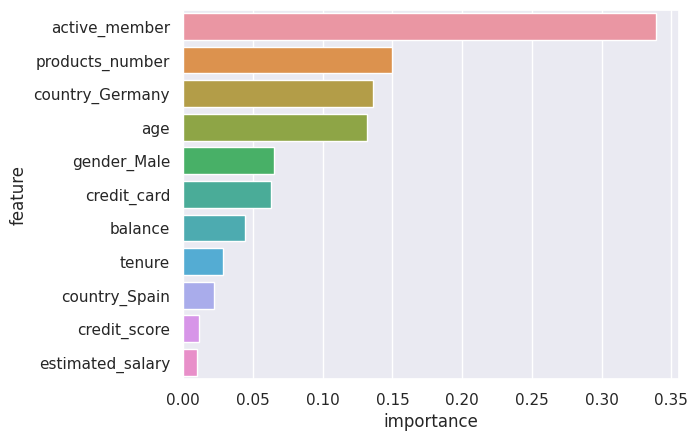

In [133]:
feature_importance = pd.DataFrame({"feature":list(X_train_sm.columns),
                                  "importance":model.feature_importances_})
feature_importance = feature_importance.sort_values("importance", ascending=False)
sns.barplot(data=feature_importance, x="importance", y="feature", orient="h")

The top three important features are found to be: active_member, products_number, country.

## Suggested actions for mitigating churn

Considering the observations and results from the EDA, modelling and feature importances, here are some actions that could be taken to reduce churn rate:


1. We need to ensure that the customers are active. The bank should invest in techniques/programs that encourage inactive customers to become active while also keeping the currently active customers to stay that way.
2. Innovative products, services and marketing could be desinged that targets Female customers.
3. Almost a third of customers left the bank in Germany. The bank could re-evaluate the quality of thier products and services in Germany. They could also invest more on marketing campaigns in general.
4. Customers having more than 2 products are very likely to leave. This is a bit unclear. More information regarding the actual product would greatly help rather than having just the "no. of products". Further investigation on each individual product would be required.
5. Customers with zero balance also tend to leave more. Special services/programs could be created for these people.

Along with all this, the bank, in general, must invest in building differentiated products and services which enable them to penetrate and dominate the market, winning against competitors.